<a href="https://colab.research.google.com/github/alawrence30/Deep-Learning/blob/main/Assignment%204/1_5_Assignment_4_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#https://www.kaggle.com/code/tilasousa/face-mask-detection-using-keras-cnn

# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import cv2
from scipy.spatial import distance
import glob
from warnings import filterwarnings
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model, load_model
from sklearn.metrics import classification_report , confusion_matrix
from skimage import io
filterwarnings("ignore")

from keras_preprocessing.image import img_to_array
from keras_preprocessing.image import load_img


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow_datasets as tfds
from keras import callbacks
from sklearn.metrics import accuracy_score
from os import listdir
from os.path import isfile, join

In [3]:
## Accuracy and Loss Graph
def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

## Validation Report
def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions)))) 

## Confusion Matrix
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

# defining callback function to avoid overfit
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 6, 
                                        restore_best_weights = True, verbose=1)

# EDA

The path is created for getting data and then I concatened dataframes of mask and without mask.

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
!unzip -u 'gdrive/My Drive/MSDS 458/Assignment 4 - Final/Data/archive.zip' -d 'gdrive/MyDrive/MSDS 458/Assignment 4 - Final/Data/'

Archive:  gdrive/My Drive/MSDS 458/Assignment 4 - Final/Data/archive.zip


In [6]:
path  = '/content/gdrive/My Drive/MSDS 458/Assignment 4 - Final/Data/Face Mask Dataset/'

In [7]:
# train dataset
train_dir = os.path.join(path, 'Train')

train_ds = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            batch_size=32,
                                                            image_size=(256,256),
                                                            shuffle=True)

Found 10000 files belonging to 2 classes.


In [8]:
# validation dataset
validation_dir = os.path.join(path, 'Validation')

validation_ds = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                            batch_size=32,
                                                            image_size=(256,256),
                                                            shuffle=True)

Found 800 files belonging to 2 classes.


In [9]:
# test dataset
test_dir = os.path.join(path, 'Test')

test_ds = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                            batch_size=32,
                                                            image_size=(256,256),
                                                            shuffle=True)

Found 992 files belonging to 2 classes.


In [10]:
class_names = train_ds.class_names
print(class_names)

['WithMask', 'WithoutMask']


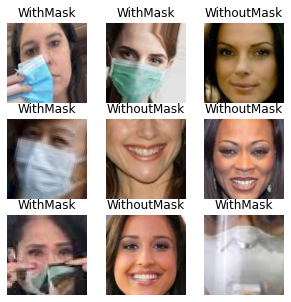

In [11]:
plt.figure(figsize=(5, 5))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
# autotune buffer to avoid I/0 block
autotune = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=autotune)
validation_ds = validation_ds.cache().prefetch(buffer_size=autotune)

# Model 1

Sequential model

Input layer

Hidden layer 1: Dense 100 units, Relu activation

Hidden layer 2: Dense 150 units, Relu activation

Output layer: Dense 2 units, Softmax activation

In [13]:
model1 = Sequential()
tf.keras.layers.Rescaling(1./255),
model1.add(keras.layers.Flatten(input_shape = [256, 256, 3]))
model1.add(layers.Dense(units = 100, activation = "relu"))
model1.add(layers.Dense(units = 150, activation = "relu"))
model1.add(layers.Dense(name = "output_layer", units = 2, activation = "softmax"))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 196608)            0         
                                                                 
 dense (Dense)               (None, 100)               19660900  
                                                                 
 dense_1 (Dense)             (None, 150)               15150     
                                                                 
 output_layer (Dense)        (None, 2)                 302       
                                                                 
Total params: 19,676,352
Trainable params: 19,676,352
Non-trainable params: 0
_________________________________________________________________


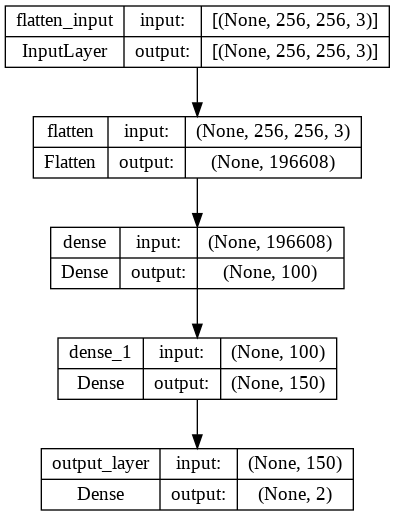

In [14]:
keras.utils.plot_model(model1, "model1.png", show_shapes=True) 

In [15]:
model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [16]:
## Train 
history1 = model1.fit(train_ds
                    ,validation_data =validation_ds
                    ,epochs=200
                    ,batch_size=64
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model1.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 3),
                    ]                                                                                                           
                   )

Epoch 1/200
313/313 [==============================] - 215s 678ms/step - loss: 518.5871 - accuracy: 0.8194 - val_loss: 596.8085 - val_accuracy: 0.6888
Epoch 2/200
313/313 [==============================] - 3s 10ms/step - loss: 179.0561 - accuracy: 0.8623 - val_loss: 43.5789 - val_accuracy: 0.9300
Epoch 3/200
313/313 [==============================] - 3s 10ms/step - loss: 23.4566 - accuracy: 0.8956 - val_loss: 8.9890 - val_accuracy: 0.9287
Epoch 4/200
313/313 [==============================] - 3s 10ms/step - loss: 18.5255 - accuracy: 0.8890 - val_loss: 7.7902 - val_accuracy: 0.9187
Epoch 5/200
313/313 [==============================] - 3s 10ms/step - loss: 6.1594 - accuracy: 0.8316 - val_loss: 0.5454 - val_accuracy: 0.7375


In [17]:
model1 = tf.keras.models.load_model("DNN_model1.h5")
print(f"Test acc: {model1.evaluate(test_ds)[1]:.3f}")

31/31 [==============================] - 24s 559ms/step - loss: 0.5045 - accuracy: 0.7399
Test acc: 0.740


## Evaluate

In [18]:
history_dict1 = history1.history
history_dict1.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [19]:
history_df1=pd.DataFrame(history_dict1)
history_df1.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
0,518.587,0.819,596.809,0.689
1,179.056,0.862,43.579,0.930
2,23.457,0.896,8.989,0.929
3,18.525,0.889,7.790,0.919
4,6.159,0.832,0.545,0.738


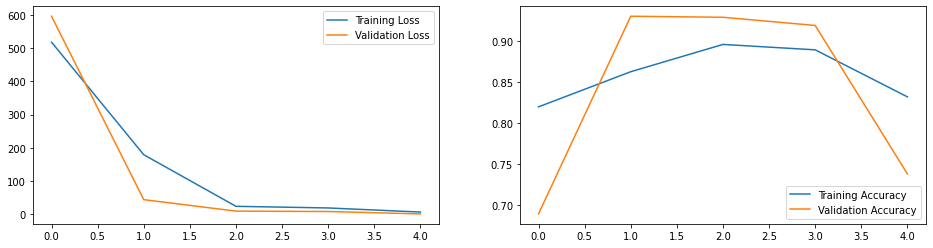

In [20]:
## Loss and acuracy
plot_history(history1)

In [21]:
test_pred1 = model1.predict(test_ds)
test_pred1 = np.argmax(test_pred1,axis = 1)
test_labels1 = np.concatenate([y for x, y in test_ds], axis=0) 

31/31 [==============================] - 1s 16ms/step


Text(0.5, 1.0, 'Confusion Matrix - Test Set')

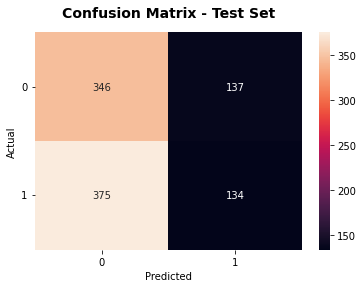

In [22]:
plt.figure(figsize=(6, 4))
ax = sns.heatmap(tf.math.confusion_matrix(
    test_labels1,
    test_pred1,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
),annot = True,
  fmt="d")
ax.set_xlabel('Predicted',fontsize = 10)
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 10) 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 14,weight = 'bold',pad=15)

In [23]:
# 0 = without mask, 1 = with mask
# 992 images in test set, model missed 446 with mask and 55 without mask

In [25]:
import numpy
from sklearn import metrics

actual1 = test_labels1
predicted1 = test_pred1

Accuracy = metrics.accuracy_score(actual1, predicted1)
Precision = metrics.precision_score(actual1, predicted1)
Sensitivity_recall = metrics.recall_score(actual1, predicted1)
Specificity = metrics.recall_score(actual1, predicted1, pos_label=0)
F1_score = metrics.f1_score(actual1, predicted1)

#metrics:
print({"Accuracy":Accuracy,"Precision":Precision,"Sensitivity_recall":Sensitivity_recall,"Specificity":Specificity,"F1_score":F1_score})

{'Accuracy': 0.4838709677419355, 'Precision': 0.4944649446494465, 'Sensitivity_recall': 0.2632612966601179, 'Specificity': 0.7163561076604554, 'F1_score': 0.3435897435897436}


In [26]:
# report
labels = ['withMask', 'withoutMask']
print(classification_report(actual1, predicted1, target_names = labels))

              precision    recall  f1-score   support

    withMask       0.48      0.72      0.57       483
 withoutMask       0.49      0.26      0.34       509

    accuracy                           0.48       992
   macro avg       0.49      0.49      0.46       992
weighted avg       0.49      0.48      0.46       992



# Model 2

Sequential model

Input layer

Hidden layer 1: Dense 250 units, Relu activation

Hidden layer 2: Dense 350 units, Relu activation

Output layer: Dense 2 units, Softmax activation

In [27]:
model2 = Sequential()
tf.keras.layers.Rescaling(1./255),
model2.add(keras.layers.Flatten(input_shape = [256, 256, 3]))
model2.add(layers.Dense(units = 250, activation = "relu"))
model2.add(layers.Dense(units = 350, activation = "relu"))
model2.add(layers.Dense(name = "output_layer", units = 2, activation = "softmax"))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 196608)            0         
                                                                 
 dense_2 (Dense)             (None, 250)               49152250  
                                                                 
 dense_3 (Dense)             (None, 350)               87850     
                                                                 
 output_layer (Dense)        (None, 2)                 702       
                                                                 
Total params: 49,240,802
Trainable params: 49,240,802
Non-trainable params: 0
_________________________________________________________________


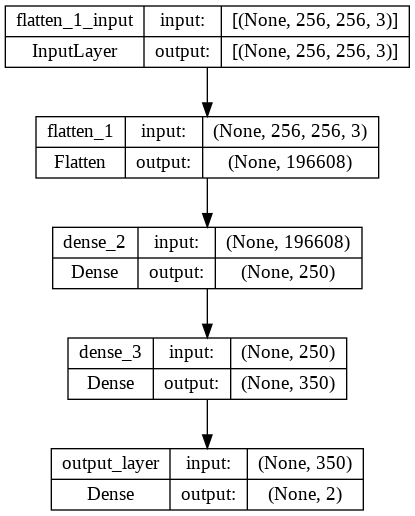

In [28]:
keras.utils.plot_model(model2, "model2.png", show_shapes=True) 

In [29]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [30]:
## Train 
history2 = model2.fit(train_ds
                    ,validation_data =validation_ds
                    ,epochs=200
                    ,batch_size=64
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model2.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 3),
                    ]                                                                                                           
                   )

Epoch 1/200
313/313 [==============================] - 4s 13ms/step - loss: 875.0792 - accuracy: 0.8135 - val_loss: 47.1917 - val_accuracy: 0.9350
Epoch 2/200
313/313 [==============================] - 3s 10ms/step - loss: 87.4848 - accuracy: 0.8923 - val_loss: 57.6328 - val_accuracy: 0.8537
Epoch 3/200
313/313 [==============================] - 4s 13ms/step - loss: 20.1575 - accuracy: 0.8402 - val_loss: 0.5599 - val_accuracy: 0.5650
Epoch 4/200
313/313 [==============================] - 4s 13ms/step - loss: 0.5131 - accuracy: 0.7980 - val_loss: 0.2711 - val_accuracy: 0.8813


In [31]:
model2 = tf.keras.models.load_model("DNN_model2.h5")
print(f"Test acc: {model2.evaluate(test_ds)[1]:.3f}")

31/31 [==============================] - 1s 17ms/step - loss: 0.3154 - accuracy: 0.8841
Test acc: 0.884


## Evaluate

In [32]:
history_dict2 = history2.history
history_dict2.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [33]:
history_df2=pd.DataFrame(history_dict2)
history_df2.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
0,875.079,0.813,47.192,0.935
1,87.485,0.892,57.633,0.854
2,20.157,0.840,0.560,0.565
3,0.513,0.798,0.271,0.881


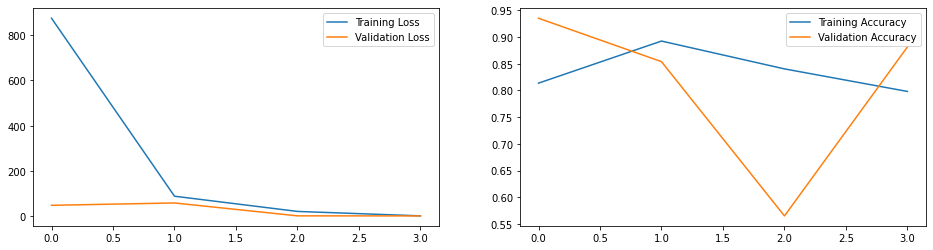

In [34]:
## Loss and acuracy
plot_history(history2)

In [35]:
test_pred2 = model2.predict(test_ds)
test_pred2 = np.argmax(test_pred2,axis = 1)
test_labels2 = np.concatenate([y for x, y in test_ds], axis=0) 

31/31 [==============================] - 1s 16ms/step


Text(0.5, 1.0, 'Confusion Matrix - Test Set')

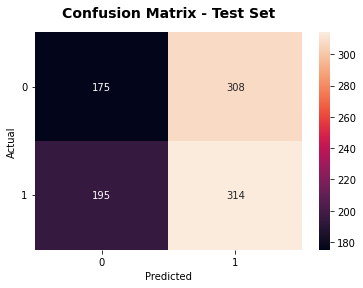

In [36]:
plt.figure(figsize=(6, 4))
ax = sns.heatmap(tf.math.confusion_matrix(
    test_labels2,
    test_pred2,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
),annot = True,
  fmt="d")
ax.set_xlabel('Predicted',fontsize = 10)
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 10) 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 14,weight = 'bold',pad=15)

In [37]:
# 0 = without mask, 1 = with mask
# 992 images in test set, model missed 72 with mask and 399 without mask

In [38]:
actual2 = test_labels2
predicted2 = test_pred2

Accuracy = metrics.accuracy_score(actual2, predicted2)
Precision = metrics.precision_score(actual2, predicted2)
Sensitivity_recall = metrics.recall_score(actual2, predicted2)
Specificity = metrics.recall_score(actual2, predicted2, pos_label=0)
F1_score = metrics.f1_score(actual2, predicted2)

#metrics:
print({"Accuracy":Accuracy,"Precision":Precision,"Sensitivity_recall":Sensitivity_recall,"Specificity":Specificity,"F1_score":F1_score})

{'Accuracy': 0.49294354838709675, 'Precision': 0.5048231511254019, 'Sensitivity_recall': 0.6168958742632613, 'Specificity': 0.36231884057971014, 'F1_score': 0.5552608311229}


In [39]:
# report
labels = ['withMask', 'withoutMask']
print(classification_report(actual2, predicted2, target_names = labels))

              precision    recall  f1-score   support

    withMask       0.47      0.36      0.41       483
 withoutMask       0.50      0.62      0.56       509

    accuracy                           0.49       992
   macro avg       0.49      0.49      0.48       992
weighted avg       0.49      0.49      0.48       992



# Model 3 - best 85%

Sequential model

Input layer

Hidden layer 1: Dense 250 units, Relu activation

Hidden layer 2: Dense 350 units, Relu activation

Hidden layer 3: Dense 250 units, Relu activation

Hidden layer 4: Dense 100 units, Relu activation

Output layer: Dense 2 units, Softmax activation

In [40]:
model3 = Sequential()
tf.keras.layers.Rescaling(1./255),
model3.add(keras.layers.Flatten(input_shape = [256, 256, 3]))
model3.add(layers.Dense(units = 250, activation = "relu"))
model3.add(layers.Dense(units = 350, activation = "relu"))
model3.add(layers.Dense(units = 250, activation = "relu"))
model3.add(layers.Dense(units = 100, activation = "relu"))
model3.add(layers.Dense(name = "output_layer", units = 2, activation = "softmax"))

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 196608)            0         
                                                                 
 dense_4 (Dense)             (None, 250)               49152250  
                                                                 
 dense_5 (Dense)             (None, 350)               87850     
                                                                 
 dense_6 (Dense)             (None, 250)               87750     
                                                                 
 dense_7 (Dense)             (None, 100)               25100     
                                                                 
 output_layer (Dense)        (None, 2)                 202       
                                                                 
Total params: 49,353,152
Trainable params: 49,353,152


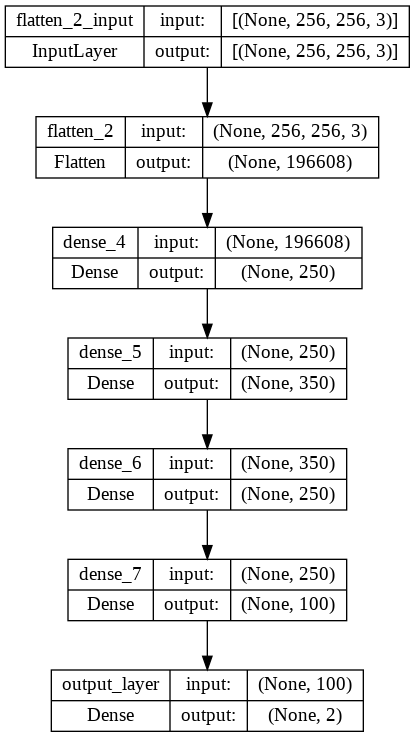

In [41]:
keras.utils.plot_model(model3, "model3.png", show_shapes=True) 

In [42]:
model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [43]:
## Train 
history3 = model3.fit(train_ds
                    ,validation_data =validation_ds
                    ,epochs=200
                    ,batch_size=64
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model3.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 3),
                    ]                                                                                                           
                   )

Epoch 1/200
313/313 [==============================] - 4s 13ms/step - loss: 738.4552 - accuracy: 0.7683 - val_loss: 37.5222 - val_accuracy: 0.8625
Epoch 2/200
313/313 [==============================] - 3s 10ms/step - loss: 20.4696 - accuracy: 0.8770 - val_loss: 47.7924 - val_accuracy: 0.8450
Epoch 3/200
313/313 [==============================] - 4s 14ms/step - loss: 9.4706 - accuracy: 0.9089 - val_loss: 7.4512 - val_accuracy: 0.8913
Epoch 4/200
313/313 [==============================] - 5s 15ms/step - loss: 3.7566 - accuracy: 0.9223 - val_loss: 5.8450 - val_accuracy: 0.9275
Epoch 5/200
313/313 [==============================] - 3s 10ms/step - loss: 77.1726 - accuracy: 0.8459 - val_loss: 33.1949 - val_accuracy: 0.7763
Epoch 6/200
313/313 [==============================] - 4s 14ms/step - loss: 6.4918 - accuracy: 0.9227 - val_loss: 2.3454 - val_accuracy: 0.9388
Epoch 7/200
313/313 [==============================] - 3s 10ms/step - loss: 3.2036 - accuracy: 0.9338 - val_loss: 2.6992 - val_ac

In [44]:
model3 = tf.keras.models.load_model("DNN_model3.h5")
print(f"Test acc: {model3.evaluate(test_ds)[1]:.3f}")

31/31 [==============================] - 1s 16ms/step - loss: 0.8612 - accuracy: 0.9526
Test acc: 0.953


## Evaluate

In [45]:
history_dict3 = history3.history
history_dict3.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [46]:
history_df3=pd.DataFrame(history_dict3)
history_df3.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
7,1.780,0.942,1.044,0.966
8,1.014,0.955,0.492,0.969
9,1.009,0.945,3.831,0.856
10,1.179,0.940,2.005,0.894
11,5.272,0.896,0.655,0.931


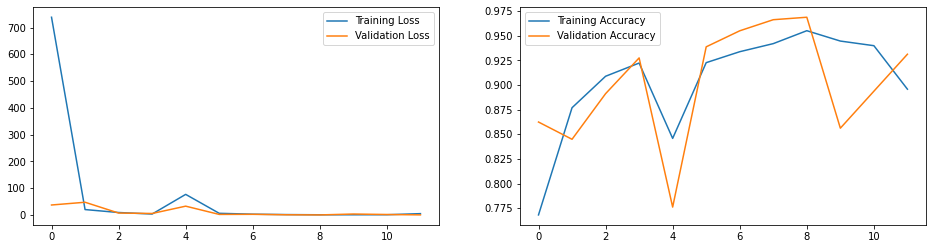

In [47]:
## Loss and acuracy
plot_history(history3)

In [48]:
test_pred3 = model3.predict(test_ds)
test_pred3 = np.argmax(test_pred3,axis = 1)
test_labels3 = np.concatenate([y for x, y in test_ds], axis=0) 

31/31 [==============================] - 1s 16ms/step


Text(0.5, 1.0, 'Confusion Matrix - Test Set')

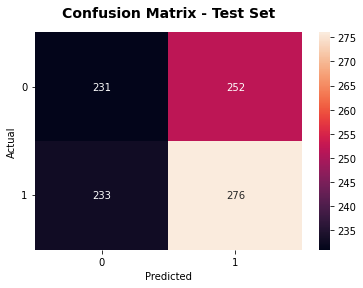

In [49]:
plt.figure(figsize=(6, 4))
ax = sns.heatmap(tf.math.confusion_matrix(
    test_labels3,
    test_pred3,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
),annot = True,
  fmt="d")
ax.set_xlabel('Predicted',fontsize = 10)
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 10) 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 14,weight = 'bold',pad=15)

In [50]:
# 0 = without mask, 1 = with mask
# 992 images in test set, model missed 299 with mask and 194 without mask

In [51]:
actual3 = test_labels3
predicted3 = test_pred3

Accuracy = metrics.accuracy_score(actual3, predicted3)
Precision = metrics.precision_score(actual3, predicted3)
Sensitivity_recall = metrics.recall_score(actual3, predicted3)
Specificity = metrics.recall_score(actual3, predicted3, pos_label=0)
F1_score = metrics.f1_score(actual3, predicted3)

#metrics:
print({"Accuracy":Accuracy,"Precision":Precision,"Sensitivity_recall":Sensitivity_recall,"Specificity":Specificity,"F1_score":F1_score})

{'Accuracy': 0.5110887096774194, 'Precision': 0.5227272727272727, 'Sensitivity_recall': 0.5422396856581533, 'Specificity': 0.4782608695652174, 'F1_score': 0.532304725168756}


In [52]:
# report
labels = ['withMask', 'withoutMask']
print(classification_report(actual3, predicted3, target_names = labels))

              precision    recall  f1-score   support

    withMask       0.50      0.48      0.49       483
 withoutMask       0.52      0.54      0.53       509

    accuracy                           0.51       992
   macro avg       0.51      0.51      0.51       992
weighted avg       0.51      0.51      0.51       992



# Model 4

Sequential model

Input layer

Hidden layer 1: Dense 250 units, Sigmoid activation

Hidden layer 2: Dense 350 units, Sigmoid activation

Hidden layer 3: Dense 250 units, Sigmoid activation

Hidden layer 4: Dense 100 units, Sigmoid activation

Output layer: Dense 2 units, Softmax activation

In [53]:
model4 = Sequential()
tf.keras.layers.Rescaling(1./255),
model4.add(keras.layers.Flatten(input_shape = [256, 256, 3]))
model4.add(layers.Dense(units = 250, activation = "sigmoid"))
model4.add(layers.Dense(units = 350, activation = "sigmoid"))
model4.add(layers.Dense(units = 250, activation = "sigmoid"))
model4.add(layers.Dense(units = 100, activation = "sigmoid"))
model4.add(layers.Dense(name = "output_layer", units = 2, activation = "softmax"))

model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 196608)            0         
                                                                 
 dense_8 (Dense)             (None, 250)               49152250  
                                                                 
 dense_9 (Dense)             (None, 350)               87850     
                                                                 
 dense_10 (Dense)            (None, 250)               87750     
                                                                 
 dense_11 (Dense)            (None, 100)               25100     
                                                                 
 output_layer (Dense)        (None, 2)                 202       
                                                                 
Total params: 49,353,152
Trainable params: 49,353,152


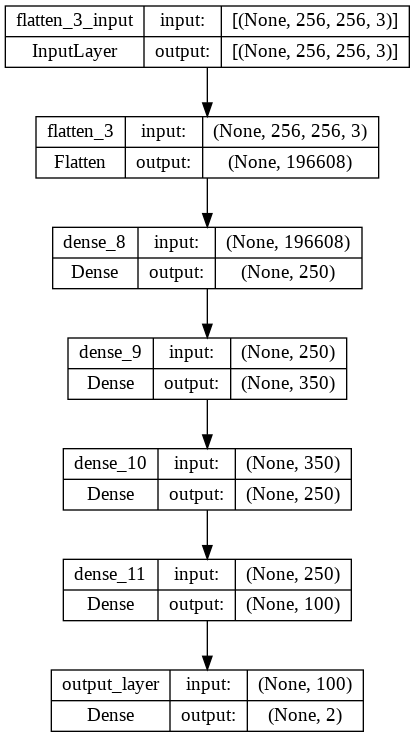

In [54]:
keras.utils.plot_model(model4, "model4.png", show_shapes=True) 

In [55]:
model4.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [56]:
## Train 
history4 = model4.fit(train_ds
                    ,validation_data =validation_ds
                    ,epochs=200
                    ,batch_size=64
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model4.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 3),
                    ]                                                                                                           
                   )

Epoch 1/200
313/313 [==============================] - 5s 13ms/step - loss: 0.7011 - accuracy: 0.5026 - val_loss: 0.7027 - val_accuracy: 0.5000
Epoch 2/200
313/313 [==============================] - 4s 14ms/step - loss: 0.6954 - accuracy: 0.5020 - val_loss: 0.6971 - val_accuracy: 0.5000
Epoch 3/200
313/313 [==============================] - 4s 14ms/step - loss: 0.6942 - accuracy: 0.5049 - val_loss: 0.6955 - val_accuracy: 0.5000
Epoch 4/200
313/313 [==============================] - 4s 14ms/step - loss: 0.6937 - accuracy: 0.5041 - val_loss: 0.6948 - val_accuracy: 0.5000


In [57]:
model4 = tf.keras.models.load_model("DNN_model4.h5")
print(f"Test acc: {model4.evaluate(test_ds)[1]:.3f}")

31/31 [==============================] - 1s 17ms/step - loss: 0.6982 - accuracy: 0.4869
Test acc: 0.487


## Evaluate

In [58]:
history_dict4 = history4.history
history_dict4.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [59]:
history_df4=pd.DataFrame(history_dict4)
history_df4.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.701,0.503,0.703,0.5
1,0.695,0.502,0.697,0.5
2,0.694,0.505,0.696,0.5
3,0.694,0.504,0.695,0.5


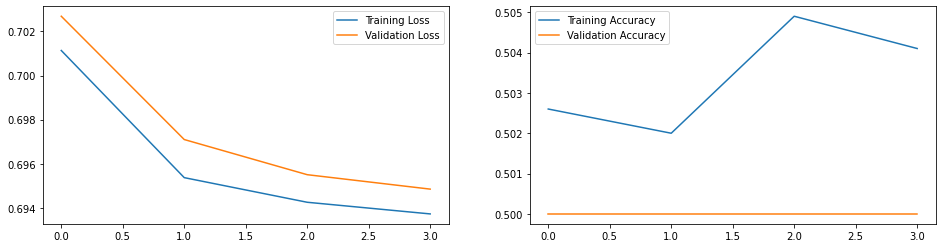

In [60]:
## Loss and acuracy
plot_history(history4)

In [61]:
test_pred4 = model4.predict(test_ds)
test_pred4 = np.argmax(test_pred4,axis = 1)
test_labels4 = np.concatenate([y for x, y in test_ds], axis=0) 

31/31 [==============================] - 1s 16ms/step


Text(0.5, 1.0, 'Confusion Matrix - Test Set')

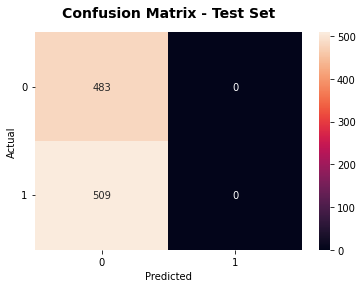

In [62]:
plt.figure(figsize=(6, 4))
ax = sns.heatmap(tf.math.confusion_matrix(
    test_labels4,
    test_pred4,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
),annot = True,
  fmt="d")
ax.set_xlabel('Predicted',fontsize = 10)
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 10) 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 14,weight = 'bold',pad=15)

In [63]:
# 0 = without mask, 1 = with mask
# 992 images in test set, model missed 0 with mask and all 483 without mask

In [64]:
actual4 = test_labels4
predicted4 = test_pred4

Accuracy = metrics.accuracy_score(actual4, predicted4)
Precision = metrics.precision_score(actual4, predicted4)
Sensitivity_recall = metrics.recall_score(actual4, predicted4)
Specificity = metrics.recall_score(actual4, predicted4, pos_label=0)
F1_score = metrics.f1_score(actual4, predicted4)

#metrics:
print({"Accuracy":Accuracy,"Precision":Precision,"Sensitivity_recall":Sensitivity_recall,"Specificity":Specificity,"F1_score":F1_score})

{'Accuracy': 0.48689516129032256, 'Precision': 0.0, 'Sensitivity_recall': 0.0, 'Specificity': 1.0, 'F1_score': 0.0}


In [65]:
# report
labels = ['withMask', 'withoutMask']
print(classification_report(actual4, predicted4, target_names = labels))

              precision    recall  f1-score   support

    withMask       0.49      1.00      0.65       483
 withoutMask       0.00      0.00      0.00       509

    accuracy                           0.49       992
   macro avg       0.24      0.50      0.33       992
weighted avg       0.24      0.49      0.32       992



# Model 5

Sequential model

Input layer

Hidden layer 1: Dense 350 units, Relu activation

Hidden layer 2: Dense 550 units, Relu activation

Hidden layer 3: Dense 300 units, Relu activation

Hidden layer 4: Dense 100 units, Relu activation

Output layer: Dense 2 units, Softmax activation

In [66]:
model5 = Sequential()
tf.keras.layers.Rescaling(1./255),
model5.add(keras.layers.Flatten(input_shape = [256, 256, 3]))
model5.add(layers.Dense(units = 350, activation = "sigmoid"))
model5.add(layers.Dense(units = 550, activation = "sigmoid"))
model5.add(layers.Dense(units = 300, activation = "sigmoid"))
model5.add(layers.Dense(units = 100, activation = "sigmoid"))
model5.add(layers.Dense(name = "output_layer", units = 2, activation = "softmax"))

model5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 196608)            0         
                                                                 
 dense_12 (Dense)            (None, 350)               68813150  
                                                                 
 dense_13 (Dense)            (None, 550)               193050    
                                                                 
 dense_14 (Dense)            (None, 300)               165300    
                                                                 
 dense_15 (Dense)            (None, 100)               30100     
                                                                 
 output_layer (Dense)        (None, 2)                 202       
                                                                 
Total params: 69,201,802
Trainable params: 69,201,802


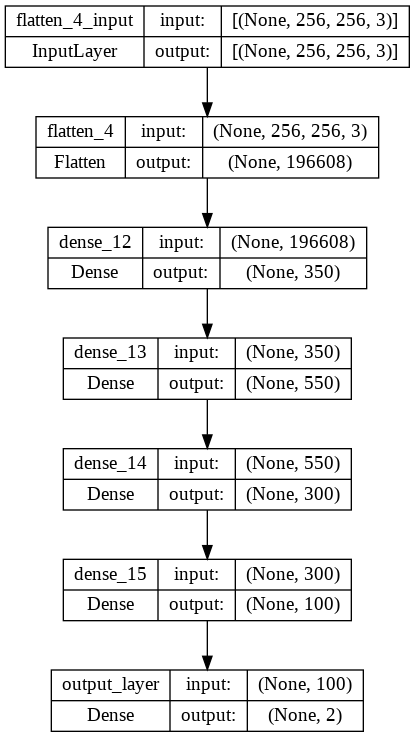

In [67]:
keras.utils.plot_model(model5, "model5.png", show_shapes=True) 

In [68]:
model5.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [69]:
## Train 
history5 = model4.fit(train_ds
                    ,validation_data =validation_ds
                    ,epochs=200
                    ,batch_size=64
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model5.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 3),
                    ]                                                                                                           
                   )

Epoch 1/200
313/313 [==============================] - 4s 13ms/step - loss: 0.6935 - accuracy: 0.5054 - val_loss: 0.6946 - val_accuracy: 0.5000
Epoch 2/200
313/313 [==============================] - 4s 14ms/step - loss: 0.6934 - accuracy: 0.5054 - val_loss: 0.6945 - val_accuracy: 0.5000
Epoch 3/200
313/313 [==============================] - 4s 14ms/step - loss: 0.6934 - accuracy: 0.5051 - val_loss: 0.6945 - val_accuracy: 0.5000
Epoch 4/200
313/313 [==============================] - 4s 14ms/step - loss: 0.6933 - accuracy: 0.5049 - val_loss: 0.6945 - val_accuracy: 0.5000


In [70]:
model5 = tf.keras.models.load_model("DNN_model5.h5")
print(f"Test acc: {model5.evaluate(test_ds)[1]:.3f}")

31/31 [==============================] - 1s 17ms/step - loss: 0.6980 - accuracy: 0.4869
Test acc: 0.487


## Evaluate

In [71]:
history_dict5 = history5.history
history_dict5.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [72]:
history_df5=pd.DataFrame(history_dict5)
history_df5.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.693,0.505,0.695,0.5
1,0.693,0.505,0.695,0.5
2,0.693,0.505,0.694,0.5
3,0.693,0.505,0.694,0.5


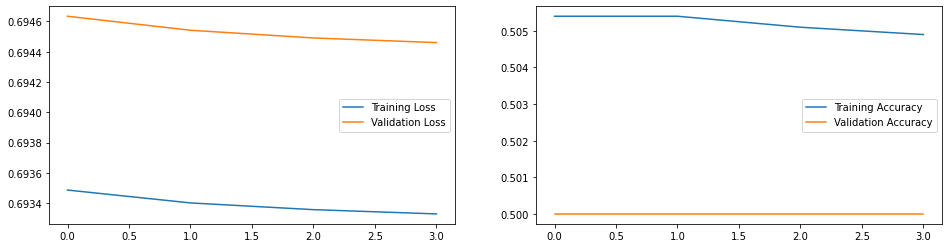

In [73]:
## Loss and acuracy
plot_history(history5)

In [74]:
test_pred5 = model5.predict(test_ds)
test_pred5 = np.argmax(test_pred5,axis = 1)
test_labels5 = np.concatenate([y for x, y in test_ds], axis=0) 

31/31 [==============================] - 1s 16ms/step


Text(0.5, 1.0, 'Confusion Matrix - Test Set')

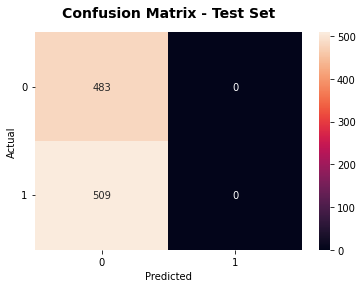

In [75]:
plt.figure(figsize=(6, 4))
ax = sns.heatmap(tf.math.confusion_matrix(
    test_labels5,
    test_pred5,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
),annot = True,
  fmt="d")
ax.set_xlabel('Predicted',fontsize = 10)
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 10) 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 14,weight = 'bold',pad=15)

In [76]:
# 0 = without mask, 1 = with mask
# 992 images in test set, model missed 0 with mask and 483 without mask

In [77]:
actual5 = test_labels5
predicted5 = test_pred5

Accuracy = metrics.accuracy_score(actual5, predicted5)
Precision = metrics.precision_score(actual5, predicted5)
Sensitivity_recall = metrics.recall_score(actual5, predicted5)
Specificity = metrics.recall_score(actual5, predicted5, pos_label=0)
F1_score = metrics.f1_score(actual5, predicted5)

#metrics:
print({"Accuracy":Accuracy,"Precision":Precision,"Sensitivity_recall":Sensitivity_recall,"Specificity":Specificity,"F1_score":F1_score})

{'Accuracy': 0.48689516129032256, 'Precision': 0.0, 'Sensitivity_recall': 0.0, 'Specificity': 1.0, 'F1_score': 0.0}


In [78]:
# report
labels = ['withMask', 'withoutMask']
print(classification_report(actual5, predicted5, target_names = labels))

              precision    recall  f1-score   support

    withMask       0.49      1.00      0.65       483
 withoutMask       0.00      0.00      0.00       509

    accuracy                           0.49       992
   macro avg       0.24      0.50      0.33       992
weighted avg       0.24      0.49      0.32       992

